https://medium.com/@ellaceroni/shors-algorithm-unravelling-encryption-with-quantum-677e97144b5a#3524

https://arxiv.org/pdf/1903.00768.pdf

In [1]:
import pennylane as qml
import numpy as np
import math as math
from fractions import Fraction
from typing import List
from math import gcd

In [2]:
N = 33 # number to factor

controlledQubits: int = math.ceil(math.log(N, 2)) # qft part
phaseEstimationQubits: int = math.ceil(math.log(N, 2)) # modular exponentiation part

In [3]:
device = qml.device("default.qubit", wires=controlledQubits+phaseEstimationQubits, shots=2048)

# Quantum fourier transform part
(not really needed, since there is QFT gate in pennylante, just wanted to implement)

In [4]:
def phaseShift(qml,k,n):
    qml.PhaseShift(-2*np.pi/2**k,wires=n)

def inverseQFT(qml,indexes):
    m = 0
    n = len(indexes)-1
    for _ in range(m,n):
        while m < n:
            qml.SWAP(wires=[indexes[m],indexes[n]])
            m += 1
            n -= 1

    n = len(indexes)-1

    qml.Hadamard(wires=indexes[n])
    controlledQubit = n-1
    for _ in range(n):
        k = (n-controlledQubit) + 1
        for j in range(n,controlledQubit,-1):
            qml.ctrl(phaseShift, control=indexes[controlledQubit])(qml,k,indexes[j])
        qml.Hadamard(wires=indexes[controlledQubit])
        controlledQubit -= 1

(<Figure size 2500x700 with 1 Axes>, <Axes: >)


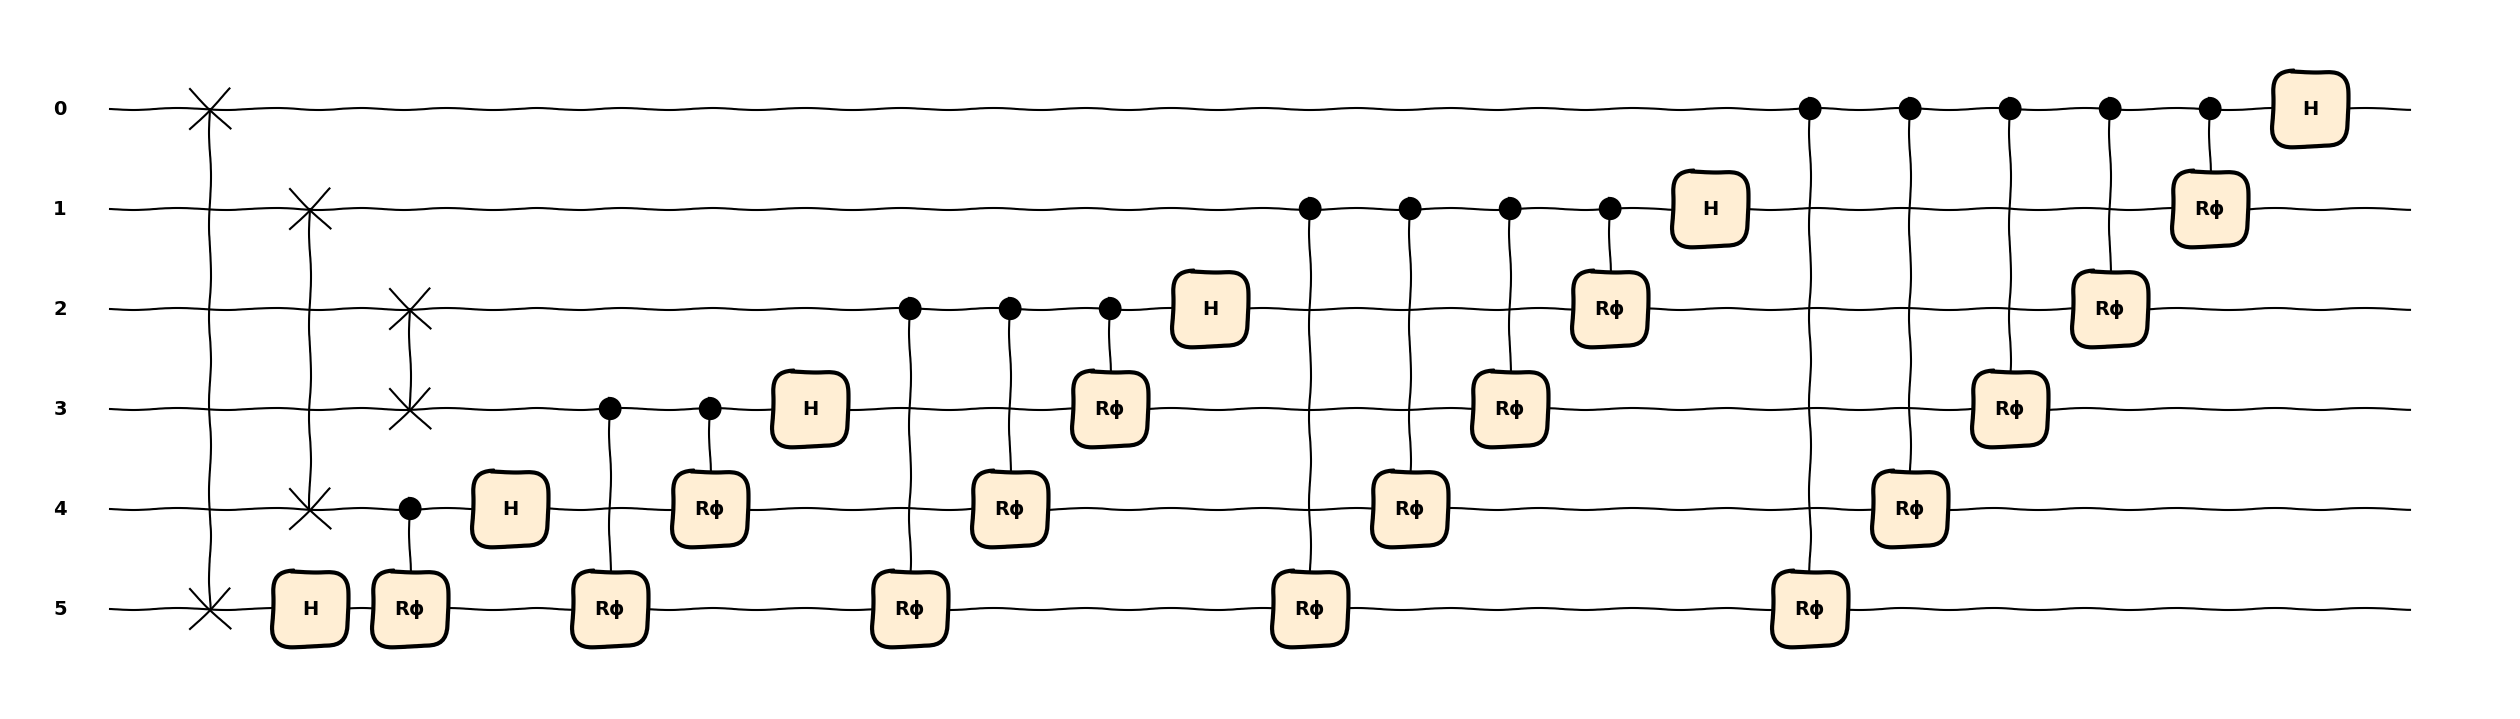

In [5]:
print(qml.draw_mpl(inverseQFT, wire_order=range(controlledQubits), style="sketch")(qml,range(controlledQubits)))

# Modular exponentiation
For  $a \mod N$ generation we use the permutation matrix, which is generated using a and N. then it is applied x times, where x is $2^i$, $i \in \mathbb{N}$.

We can also try to construct the gate system which should do the same job as the permutation matrix(left the N=15 case).

In [6]:
def generateModularExponentiationMatrix(a: int, N: int) -> np.ndarray:
    qubits: int = math.ceil(math.log(N, 2))
    matrix: np.ndarray = np.zeros((2**qubits, 2**qubits))
    for i in range(0, 2**qubits):
        if i < N:
            matrix[a * i % N][i] = 1
        else:
            matrix[i][i] = 1
    return matrix

def aMod15(qml,a,timesToRepeatGate, qubits):
    for _ in range(timesToRepeatGate):
        if N == 15:
            if a in [2,13]:
                qml.SWAP(wires=[qubits[0],qubits[1]])
                qml.SWAP(wires=[qubits[1],qubits[2]])
                qml.SWAP(wires=[qubits[2],qubits[3]])
            if a in [7,8]:
                qml.SWAP(wires=[qubits[2],qubits[3]])
                qml.SWAP(wires=[qubits[1],qubits[2]])
                qml.SWAP(wires=[qubits[0],qubits[1]])
            if a == 11:
                qml.SWAP(wires=[qubits[1],qubits[3]])
                qml.SWAP(wires=[qubits[0],qubits[2]])
            if a in [7,11,13]:
                for qubit in range(4):
                    qml.PauliX(wires=qubits[qubit])
            if a == 4:
                qml.SWAP(wires=[qubits[2],qubits[3]])
            if a == 14:
                for qubit in range(4):
                    qml.PauliX(wires=qubits[qubit])
        else:
            qml.ControlledQubitUnitary(generateModularExponentiationMatrix(a, N), control_wires=[math.log(timesToRepeatGate, 2)] , wires=qubits)

def modExp(qml, controlledQubits: int, phaseEstimationQubits: int ,a: int):
    for x in range (controlledQubits):
        if N == 15:
            qml.ctrl(aMod15, control=x)(qml,a, 2**x, range(controlledQubits,controlledQubits+phaseEstimationQubits))
        else:
            aMod15(qml,a, 2**x, range(controlledQubits,controlledQubits+phaseEstimationQubits))

## examples

a=11:

(<Figure size 400x800 with 1 Axes>, <Axes: >)


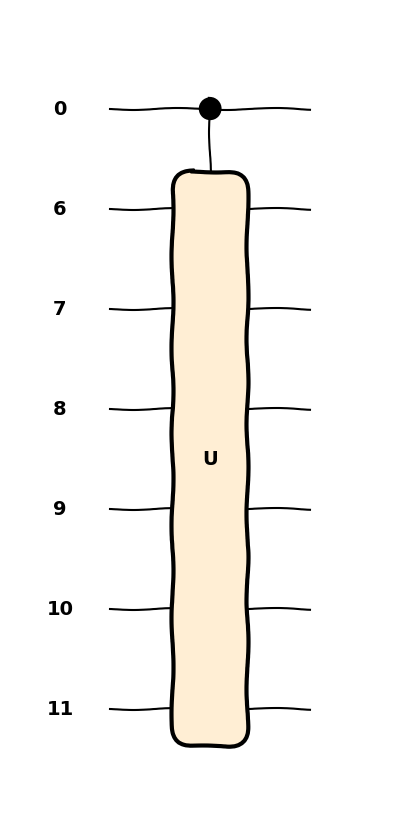

In [7]:
a=11
print(qml.draw_mpl(aMod15, wire_order=range(phaseEstimationQubits),style="sketch")(qml,a,1,range(controlledQubits,phaseEstimationQubits+controlledQubits)))

a=7

(<Figure size 6600x1300 with 1 Axes>, <Axes: >)


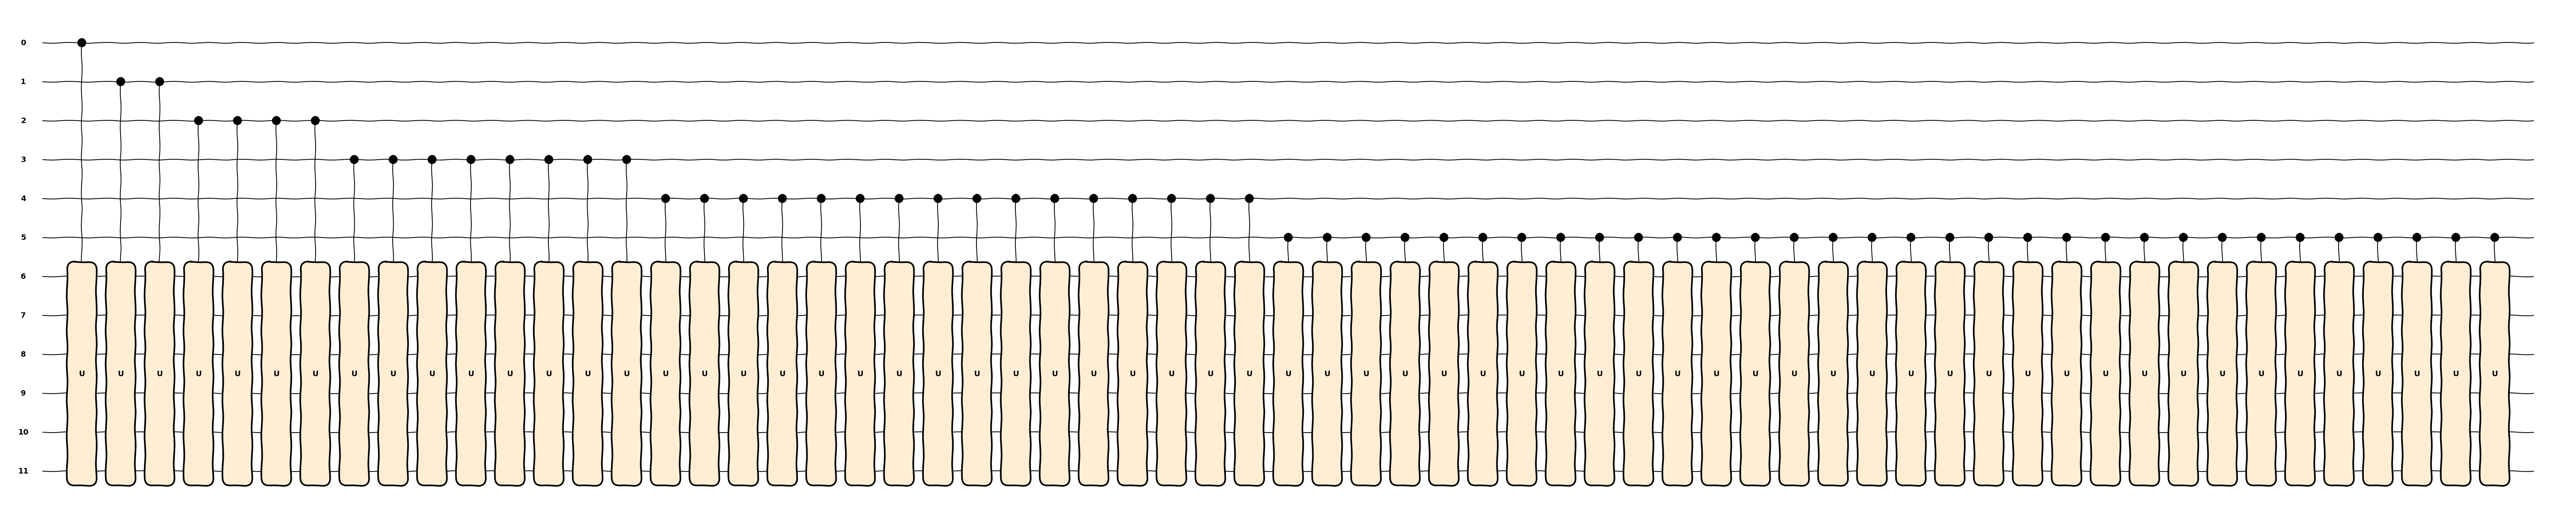

In [8]:
print (qml.draw_mpl(modExp, wire_order=range(controlledQubits+phaseEstimationQubits),style="sketch")(qml,controlledQubits,phaseEstimationQubits,14))

# Shor circuit construction

We construct shor algoritm circuit:
- Add list of hadamard gates
- Add quantum phase estimation
- Add quantum fourier transform
- measure qubits

In [9]:
@qml.qnode(device)
def shor(controlledQubits,phaseEstimationQubits,a, returnCounts = False):
    for x in range(controlledQubits):
        qml.Hadamard(wires=x)

    qml.PauliX(wires=controlledQubits+phaseEstimationQubits-1)

    modExp(qml,controlledQubits,phaseEstimationQubits,a)

    inverseQFT(qml,range(controlledQubits))

    for x in range(controlledQubits):
        qml.measure(wires=x)

    if returnCounts:
        return qml.counts(wires=range(controlledQubits))
    else:
        return qml.sample(wires=range(controlledQubits))

In [10]:
def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [11]:
def getCoprimeListWithEvenPeriod(N: int) -> List[int]:
    aList: List[int] = []
    for i in range(N - 1):
        if gcd(i, N) == 1 and i != 1:
            remainder = 0
            count = 1
            while remainder != 1:
                if remainder == 0:
                    remainder = (i) % N
                remainder = (remainder * i) % N
                count += 1
            if count % 2 == 0:
                if (
                    gcd(i ** (count // 2) - 1, N) != 1
                    and gcd(i ** (count // 2) + 1, N) != 1
                ):
                    aList.append(i)
    return aList

# Running the whole algorithm

Shor’s Algorithm.
Input: A positive integer N with n = log2 N!.
Output: A factor p of N if it exists.

- Step 1. Randomly choose an integer a such that 1 < a < N. Perform Euclid’s algorithm to determine GCD(a, N). If the GCD is not 1, then return it and exit. (for demonstration purposes we skip this part)
- Step 2. Use quantum circuit to find a period r.
- Step 3. If r is odd or if ar ≡ −1 Mod N, then return to Step 2 and choose another a.
- Step 4. Use Euclid’s algorithm to calculate $GCD(a^{(r/2 + 1)}, N)$ and $GCD(a^{(r/2 −1)}, N).$ Return at least one of the nontrivial solutions

In [12]:
coprimeListWithEvenPeriods: List[int] = getCoprimeListWithEvenPeriod(N)
print(coprimeListWithEvenPeriods)

if len(coprimeListWithEvenPeriods) == 0:
    raise Exception("No coprime list with even periods found")

a = -1
while a not in coprimeListWithEvenPeriods:
    a = np.random.randint(2, N)

print("trying with a=", a, "and N=", N)
factorFound = False
attempts = 0
while factorFound == False:
    attempts += 1
    print("attempts", attempts,end=' ')
    counts = shor(controlledQubits,phaseEstimationQubits,a, returnCounts=False)
    r, phase = processMeasurement(counts[0], controlledQubits)
    print("corresponding phase", phase, " r ", r)
    if phase != 0 and r % 2 == 0:
        guesses = [math.gcd(a ** (r // 2) - 1, N), math.gcd(a ** (r // 2) + 1, N)]
        print("guesses", guesses)
        for guess in guesses:
            if guess not in [1, N] and N % guess == 0:
                factorFound = True
                print("Found non trivial factors of", N, "; ", guess, "and", N // guess)
                break

[5, 7, 10, 13, 14, 19, 20, 23, 26, 28]
trying with a= 23 and N= 33
attempts 1 corresponding phase 0.0  r  1
corresponding phase 0.0  r  1
attempts 2 corresponding phase 0.0  r  1
corresponding phase 0.0  r  1
attempts 3 corresponding phase 0.046875  r  1
corresponding phase 0.046875  r  1
attempts 4 corresponding phase 0.0  r  1
corresponding phase 0.0  r  1
attempts 5 corresponding phase 0.0  r  1
corresponding phase 0.0  r  1
attempts 6 corresponding phase 0.0  r  1
corresponding phase 0.0  r  1
attempts 7 corresponding phase 0.015625  r  1
corresponding phase 0.015625  r  1
attempts 8 corresponding phase 0.109375  r  6
corresponding phase 0.109375  r  6
guesses [11, 3]
Found non trivial factors of 33 ;  11 and 3


{'000000': 1024, '000001': 413, '000011': 219, '000101': 50, '000111': 157, '001001': 21, '001011': 34, '001101': 11, '001111': 61, '010001': 5, '010011': 7, '010111': 17, '011011': 2, '011111': 11, '100001': 3, '100011': 2, '100111': 7, '101101': 1, '101111': 1, '110111': 2}


(<Figure size 8900x1300 with 1 Axes>, <Axes: >)

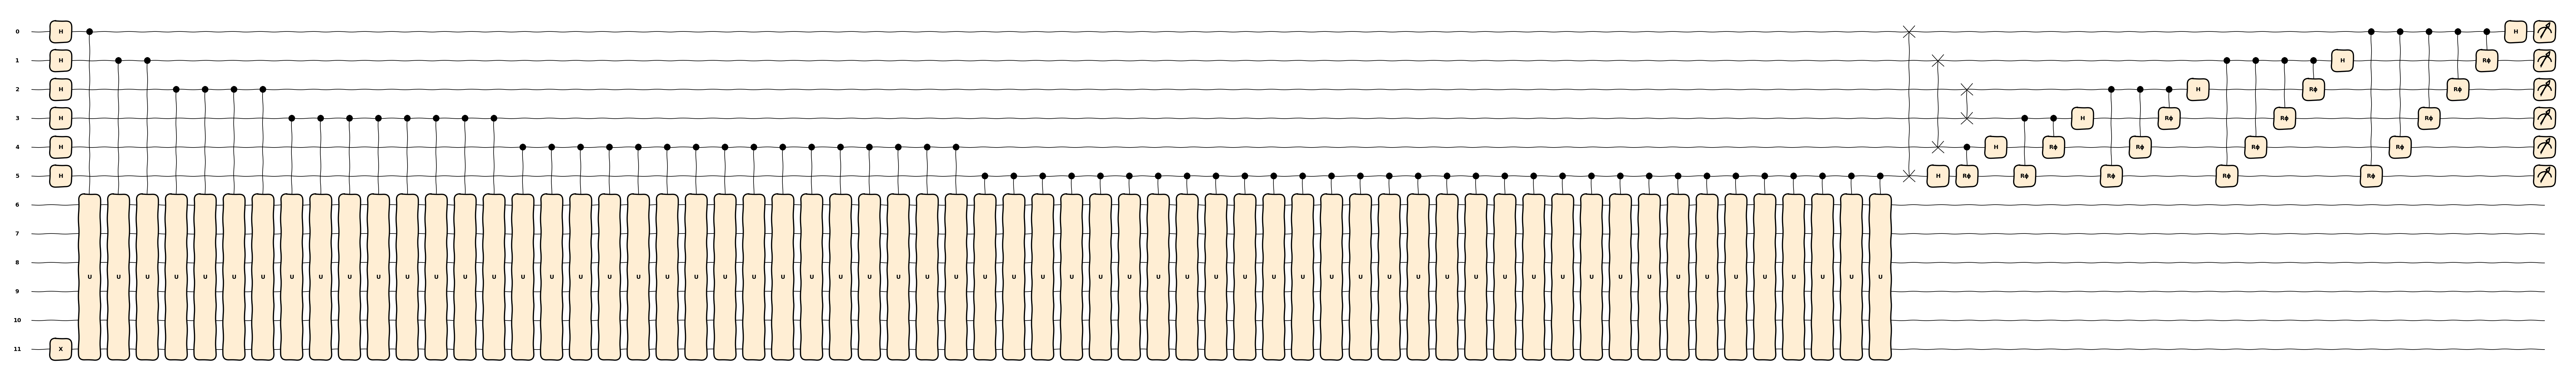

In [13]:
results = shor(controlledQubits,phaseEstimationQubits,a, returnCounts=True)
print (results)
qml.draw_mpl(shor, wire_order=range(controlledQubits+phaseEstimationQubits),style="sketch")(controlledQubits,phaseEstimationQubits,a)